# 전이 학습(Transfer Learning)

<img src = "./img/transfer_learning.png">

- 일반적으로 합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요함
- 하지만 큰 데이터 셋을 확보하고 훈련시키는 데에 많은 돈과 시간이 필요
- 이러한 문제를 해결하기 위해 전이 학습을 이용
- 전이 학습(transfer learning)
     - 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용 하는 것 
         - 이 때 아주 큰 데이터셋을 사용하여 훈련된 모델을 사전 학습 모델(사전 훈련된 모델)이라고 함
     - 전이 학습을 이용하면 비교적 적은 수의 데이터를 가지고도 원하는 과제를 해결할 수 있음

## 특성 추출 기법(Feature extractor)

<img src = "./img/feature_extractor.jpg">

- 사전 학습 모델을 가져온 후 완전연결층 부분만 새로 만듦
- 학습할 때는 완전연결층만 학습하고 나머지 계층은 학습되지 않도록 함
    - 데이터 분류기 (완전 연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분
    
- 자주 사용되는 이미지 분류 사전학습 모델
    - Xception
    - Inception V3
    - ResNet50
    - VGG16
    - VGG19
    - MobileNet

In [1]:
import os
import time
import copy
import glob
import shutil
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
data_path = "./data/catanddog/train"

transform = transforms.Compose([
    transforms.Resize([256, 256]), # 가로세로 사이즈를 256 * 256으로 변경
    transforms.RandomResizedCrop(224), # 랜덤하게 사이즈 조정
    transforms.RandomHorizontalFlip(), # 랜덤하게 사이즈 조정
    transforms.ToTensor(),
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32, # 데이터셋을 32개씩 잘라서 가져옴
    num_workers = 8, # 병렬처리
    shuffle = True # 셔플
)

In [5]:
print(len(train_dataset))

385


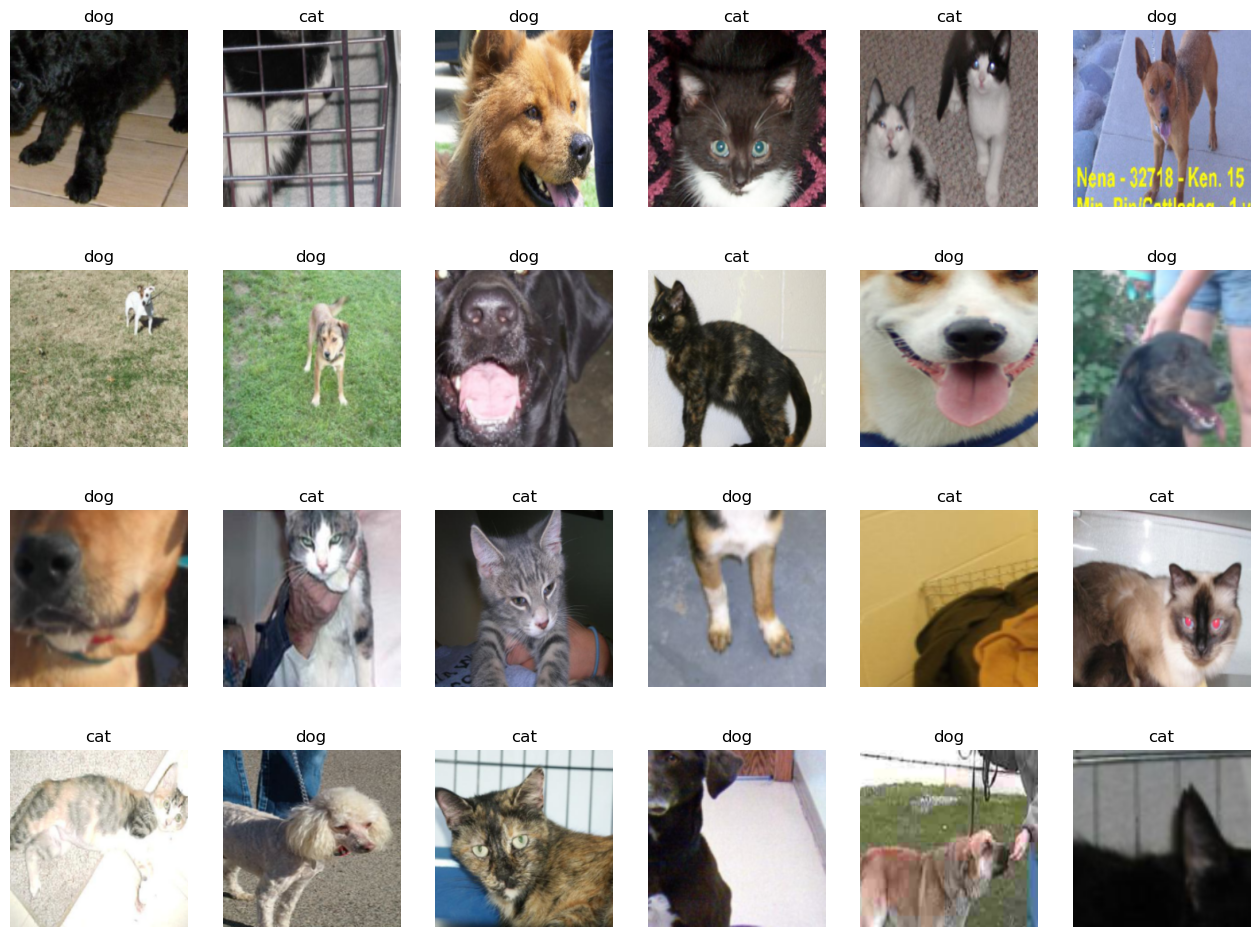

In [6]:
#  학습에 사용될 이미지 출력
samples, labels = next(iter(train_loader)) # train_loader에서 데이터를 하나씩 꺼내오기
classes = {0 : "cat", 1 : "dog"}

fig = plt.figure(figsize = (16, 24))

for i in range(24):
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis("off")
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
    # 3, 224, 224 크기를 224, 224, 3으로 변환
    
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

In [7]:
samples.shape

torch.Size([32, 3, 224, 224])

In [8]:
np.transpose(samples[0].numpy(), (1, 2, 0)).shape

(224, 224, 3)

# 사전학습 모델 준비

In [11]:
# weights = "IMAGENET1K_V1" : IMAGENET1K_V1 데이터로 사전 학습된 가중치를 사용하겠다
resnet18 = models.resnet18(weights="IMAGENET1K_V1") # 사전학습 모델

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ITSC/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:02<00:00, 21.6MB/s]


## ResNet18

- 50개의 계층으로 구성된 합성곱 신경망
- ImageNet 데이터베이스의 100만개가 넘는 영상을 이용하여 훈련된 신경망
- 입력 제약이 매우 크고 충분함 메모리(RAM)가 없으면 학습 속도가 느려지는 단점이 있음


In [12]:
def set_parameter_requires_grad(model, feature_extracting = True):
    '''
    ResNet18이 파라미터 학습을 하지 않도록 고정
    '''
    if feature_extracting:
        for param in model.parameters(): # 모델 전체의 파라미터, 가중치와 y절편
            param.requires_grad = False # 
            # 역전파 중 파라미터들에 대한 변화를 계산할 필요 없음

In [13]:
set_parameter_requires_grad(resnet18)

## 완전 연결층 추가

In [15]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
resnet18.fc = nn.Linear(512, 2) # 클래스가 2개

In [16]:
# 모델 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0165, -0.0398,  0.0065,  ...,  0.0081, -0.0410, -0.0328],
        [ 0.0291,  0.0007,  0.0330,  ...,  0.0326,  0.0404,  0.0099]])
fc.bias tensor([0.0292, 0.0416])


# 모델 학습

In [30]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True): 
    '''
    파라미터 : (모델, 학습데이터, 손실 함수, 옵티마이저, 장치)
    '''
    since = time.time() # 현재 시간
    acc_history = [] #
    loss_history = []
    best_acc = 0.0 # 최고 기록
    
    for epoch in range(num_epochs): 
        print(f"Epoch {epoch}/{num_epochs - 1}") # 로그 찍기
        print("-" * 10)
        
        running_loss = 0.0 # 로스
        running_corrects = 0 # 정확도
        # 에포크 돌 때마다 초기화 됨
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device) # 입력데이터
            labels = labels.to(device) # 종속변수
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) # 순전파
            loss = criterion(outputs, labels) # 손실계산
            _, preds = torch.max(outputs, 1) # 결과물 중에서 최댓값의 인덱스
            loss.backward() # 손실값에 따른 그레디언트 계산
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) # 미니배치의 로스 누적시켜서 저장
            # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            # 한 배치 안에서의 loss
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        # 1 epoch 계산이 끝나고 나서 해당 에포크의 로스와 정확도 계산
        
        print(f"Loss: {epoch_loss:.4f} ACC: {epoch_acc:.4f}") # 로그 찍기
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            # best_acc으로 바꾸기
            
        acc_history.append(epoch_acc.item()) # 정확도 히스토리 남기기
        loss_history.append(epoch_loss) # 로스 히스토리 남기기
        torch.save(model.state_dict(), os.path.join("./data/catanddog/", f"{epoch:02}.pth"))
        # 파이토치 모델 저장
        # model.state_dict() = 파라미터 저장
        print()
    
    time_elapsed = time.time() - since # 몇 초 걸렸는지 계산
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Acc: {best_acc:.4f}")
    return acc_history, loss_history

In [31]:
params_to_update = []

# 어떤 파라미터들이 옵티마지어로 전달되는지 설정
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)

fc.weight
fc.bias


In [32]:
optimizer = optim.Adam(params_to_update)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

In [34]:
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer,
                                             device)

Epoch 0/12
----------
Loss: 0.1600 ACC: 0.9299

Epoch 1/12
----------
Loss: 0.1763 ACC: 0.9169

Epoch 2/12
----------
Loss: 0.1851 ACC: 0.9091

Epoch 3/12
----------
Loss: 0.1821 ACC: 0.9195

Epoch 4/12
----------
Loss: 0.1673 ACC: 0.9169

Epoch 5/12
----------
Loss: 0.1782 ACC: 0.9117

Epoch 6/12
----------
Loss: 0.1831 ACC: 0.9221

Epoch 7/12
----------
Loss: 0.1576 ACC: 0.9351

Epoch 8/12
----------
Loss: 0.1672 ACC: 0.9325

Epoch 9/12
----------
Loss: 0.1614 ACC: 0.9377

Epoch 10/12
----------
Loss: 0.1884 ACC: 0.9247

Epoch 11/12
----------
Loss: 0.1895 ACC: 0.9221

Epoch 12/12
----------
Loss: 0.1585 ACC: 0.9351

Training complete in 3m 19s
Best Acc: 0.9377


# 테스트 데이터 평가

In [35]:
test_path = "./data/catanddog/test"

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = True
)

In [36]:
print(len(test_dataset))

98


In [40]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0
    
    saved_models = glob.glob("./data/catanddog/" + "*.pth")
    # 경로에서 pth 확장자를 갖는 파일을 가져오기
    saved_models.sort()
    print("saved_model", saved_models)
    
    for model_path in saved_models:
        print("Loading model", model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad(): # 훈련을 하지 않으므로 자동 미분 계산 필요 없음
                outputs = model(inputs)
                
            _, preds = torch.max(outputs.data, 1) # 주어진 텐서 배열의 최댓값의 index를 반환
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.cpu().eq(labels.cpu()).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f"Acc: {epoch_acc:.4f}")
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        print()
    
    time_elapsed = time.time() - since
    print(f"Validation complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Acc: {best_acc:.4f}")
    
    return acc_history

In [41]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data/catanddog\\00.pth', './data/catanddog\\01.pth', './data/catanddog\\02.pth', './data/catanddog\\03.pth', './data/catanddog\\04.pth', './data/catanddog\\05.pth', './data/catanddog\\06.pth', './data/catanddog\\07.pth', './data/catanddog\\08.pth', './data/catanddog\\09.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth']
Loading model ./data/catanddog\00.pth
Acc: 0.9592

Loading model ./data/catanddog\01.pth
Acc: 0.9490

Loading model ./data/catanddog\02.pth
Acc: 0.9286

Loading model ./data/catanddog\03.pth
Acc: 0.9592

Loading model ./data/catanddog\04.pth
Acc: 0.9388

Loading model ./data/catanddog\05.pth
Acc: 0.9694

Loading model ./data/catanddog\06.pth
Acc: 0.9490

Loading model ./data/catanddog\07.pth
Acc: 0.9694

Loading model ./data/catanddog\08.pth
Acc: 0.9592

Loading model ./data/catanddog\09.pth
Acc: 0.9694

Loading model ./data/catanddog\10.pth
Acc: 0.9694

Loading model ./data/catanddog\11.pth
Acc: 0.9490

Loading mod

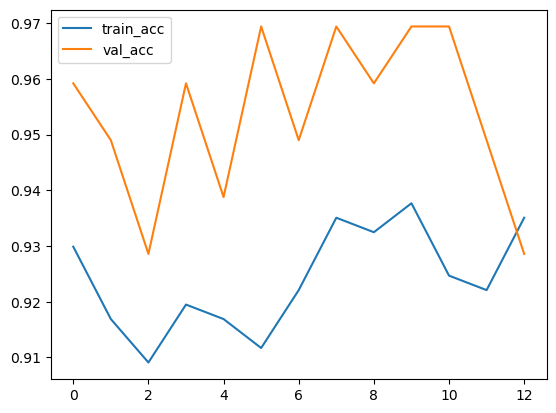

In [42]:
plt.plot(train_acc_hist, label = "train_acc")
plt.plot(val_acc_hist, label = "val_acc")
plt.legend()
plt.show()

# 예측 이미지 출력

In [43]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    # 기존 텐서의 내용을 복사한 텐서를 생성
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1) # 값을 특정 범위로 제한
    return image

- 텐서 복사 명령어 비교
    - tensor.clone()
        - 메모리 : 새롭게 할당
        - 계산 그래프에 계속 상주(기울기에 영향을 줌)
        
    - tensor.detach()
        - 메모리 : 공유해서 사용
        - 계산 그래프에 계속 상주하지 않음(기울기에 영향을 안 줌)
        
    - tensor.clone().detach()
        - 메모리 : 새롭게 할당
        - 계산 그래프에 상주하지 않음

In [44]:
classes = {0 : "cat", 1 : "dog"}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = resnet18(images.to(device)) # 순전파
_, preds = torch.max(output, 1)

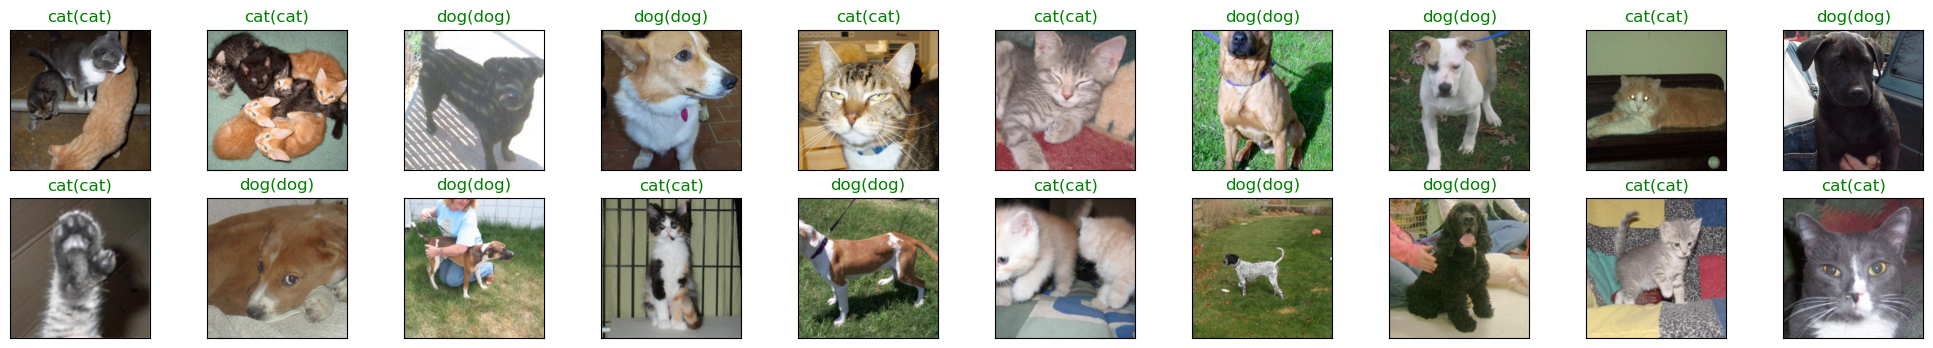

<Figure size 640x480 with 0 Axes>

In [46]:
fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    # 행, 열, 인덳, 축(삭제) (축을 적은 이유는 삭제하기 위해서)
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title(f"{str(classes[preds[idx].item()])}({str(classes[labels[idx].item()])})",
                color = ("green" if preds[idx] == labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)